In [1]:
from fastai import *
from fastai.vision import *
import pretrainedmodels
from sklearn.model_selection import StratifiedKFold

# Data

In [2]:
path     = pathlib.Path("E:/Datasets/TFM/histologyDS2828")
csv_path = path / "imageClasses.txt"
df       = pd.read_csv(csv_path, header=None, delim_whitespace=True, names=['Image', 'Label'])
df       = df.replace({'Label': {1:"Conective", 2:"Ephitelial", 3:"Muscular", 4:"Nervous"}})

###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df.Image.values
y = df.Label.values
train_idxs_fold = []
valid_idxs_fold = []
cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)

##################################### Src data

src  = (ImageItemList.from_df(df, path, folder='imgs')
        .split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0])
        .label_from_df(cols='Label'))

def get_data(bs,size):
    return (src.transform(get_transforms(flip_vert=True, max_warp=None), size=size)
            .databunch(bs=bs).normalize(imagenet_stats))

data = get_data(16,224)

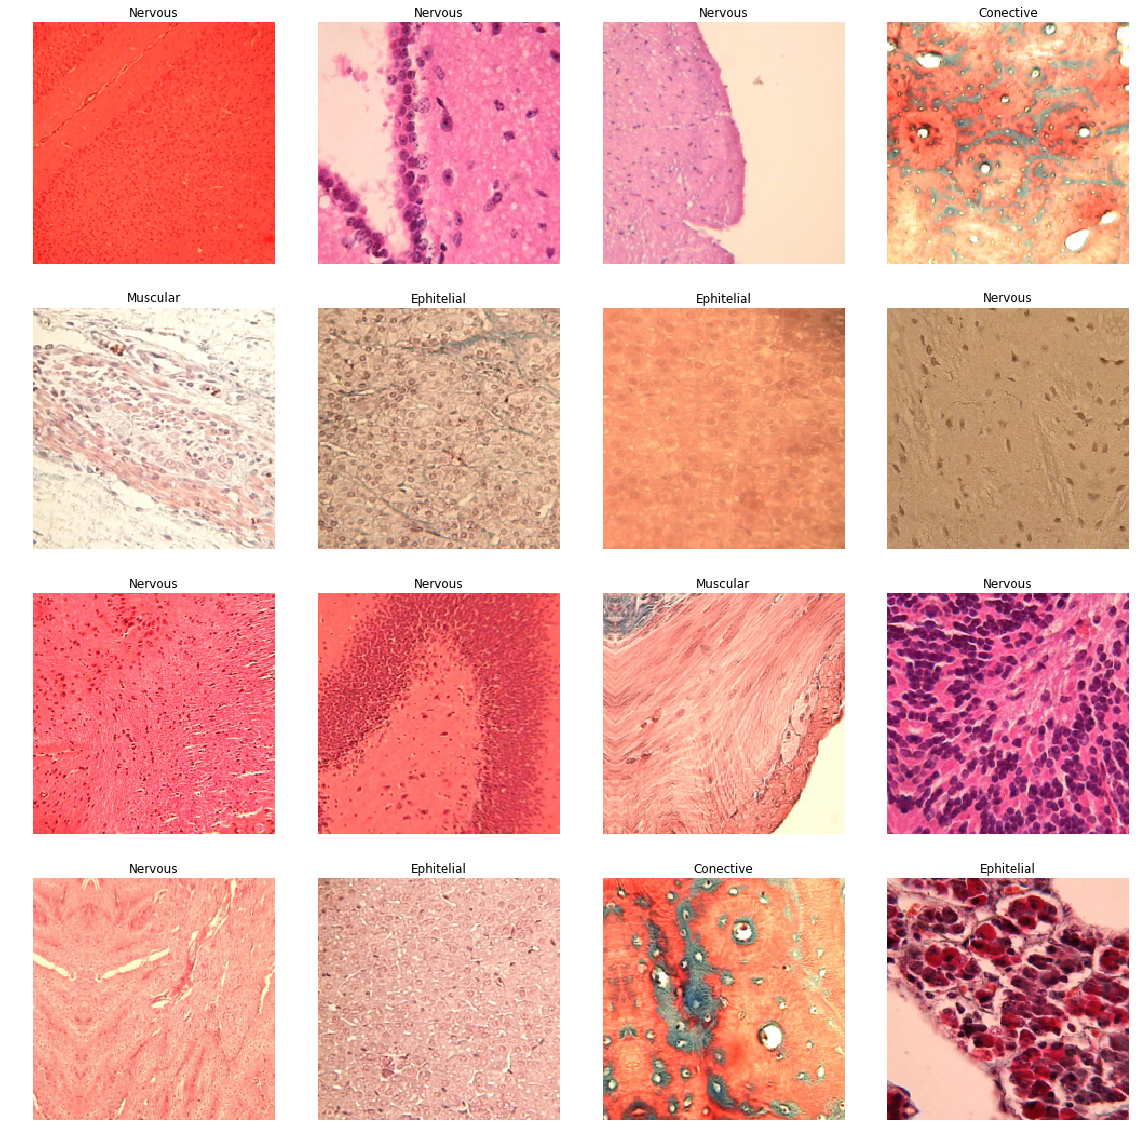

In [3]:
data.show_batch(rows=4)

# Training

In [8]:
arch   = models.resnet34 # models.resnet50

#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)

learn = create_cnn(data, arch, metrics=accuracy)

In [11]:
learn.recorder.plot_lr(show_moms=True)

AttributeError: 'Learner' object has no attribute 'recorder'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


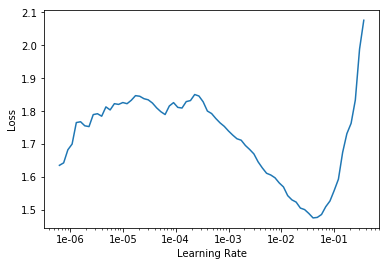

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
1-0.145133

0.854867

In [14]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.969502,0.880336,0.707965
2,0.760219,0.470782,0.814159
3,0.500998,0.358371,0.881416


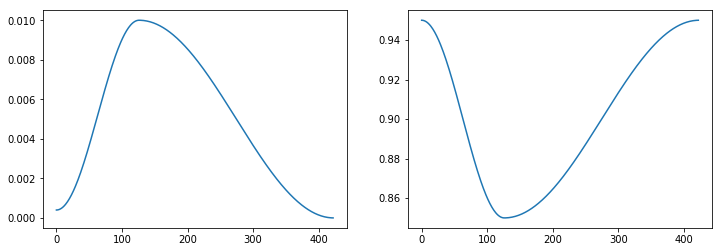

In [15]:
learn.recorder.plot_lr(show_moms=True)

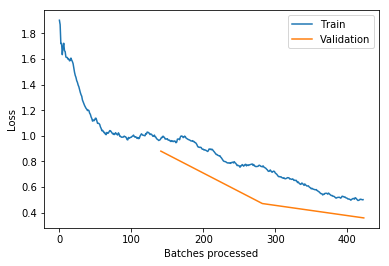

In [16]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


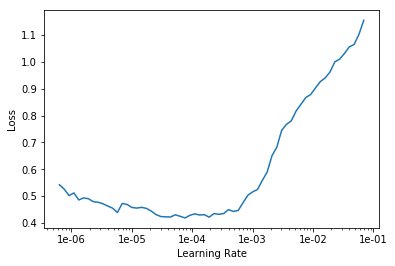

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.423296,0.386015,0.861947
2,0.440403,0.318596,0.876106
3,0.275967,0.196806,0.936283
4,0.249080,0.178755,0.938053


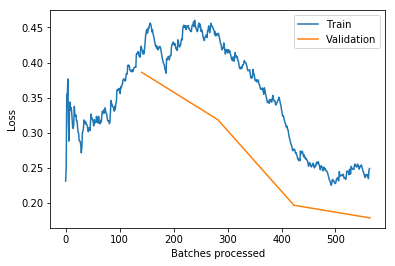

In [24]:
learn.recorder.plot_losses()

# Results

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

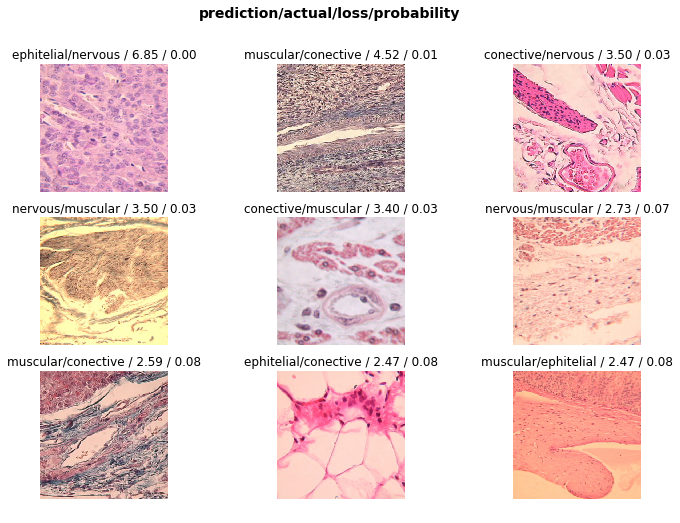

In [26]:
interp.plot_top_losses(9, figsize=(12,8))

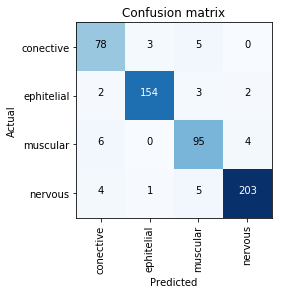

In [27]:
interp.plot_confusion_matrix()

In [28]:
interp.most_confused(min_val=2)

[('muscular', 'conective', 6),
 ('conective', 'muscular', 5),
 ('nervous', 'muscular', 5),
 ('muscular', 'nervous', 4),
 ('nervous', 'conective', 4),
 ('conective', 'ephitelial', 3),
 ('ephitelial', 'muscular', 3)]

# Cadene pretrained models
See available pretrained models

In [8]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [4]:
def cadene_model(model_name):
    def mymodel(pretrained=True, **kwargs):
        return pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    return mymodel

model = cadene_model('se_resnext50_32x4d')                # this returns a function
learn = create_cnn(data, model, metrics=accuracy, cut=-2) # cut parameter is different for each model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


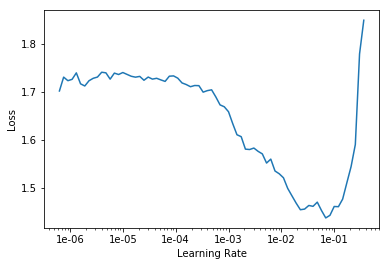

In [34]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.839634,0.631370,0.810526
2,0.607223,0.293917,0.887719
3,0.445466,0.239536,0.919298


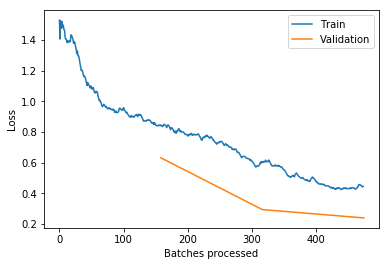

In [37]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


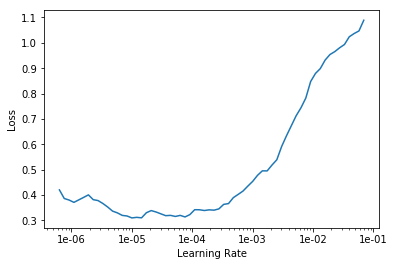

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(4, 1e-5)

epoch,train_loss,valid_loss,accuracy
1,0.375841,0.208565,0.933333
2,0.348767,0.185677,0.947368
3,0.328749,0.185470,0.936842
4,0.352022,0.181701,0.943860


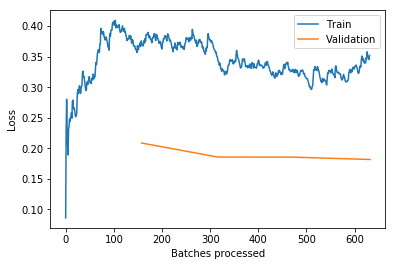

In [40]:
learn.recorder.plot_losses()

In [45]:
learn.save("se_resnext50-3+4-epochs")

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

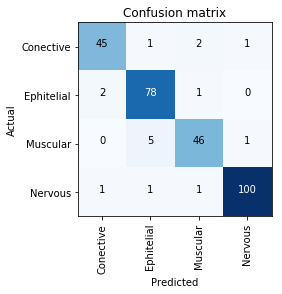

In [42]:
interp.plot_confusion_matrix()

## Bigger images

In [5]:
data  = get_data(10, 480)
model = cadene_model('se_resnext50_32x4d')

learn = create_cnn(data, model, metrics=accuracy, cut=-2) # cut parameter is different for each model
learn.load("se_resnext50-3+4-epochs");

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


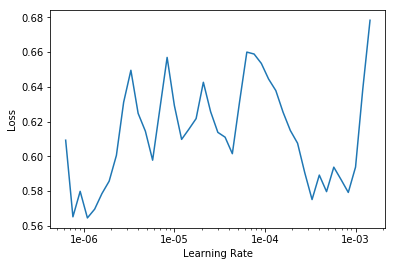

In [6]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.571343,0.207742,0.908772
2,0.406786,0.164769,0.940351
3,0.310920,0.160478,0.933333
